In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from math import ceil

In [13]:
start = datetime(2022, 12, 27, 8, 44)
test_duration = np.timedelta64(8, 'h')

def to_delta(df, column):
    print(start)
    df[column] = df[column].apply(lambda dt: dt - start)
    df.set_index(column, inplace=True, drop=False)

def load_cloudwatch(filename):
    logs = pd.read_csv(filename)
    logs = logs.sort_values(by='timestamp')
    logs['timestamp'] = pd.to_datetime(logs['timestamp'])
    logs = logs[logs['timestamp'] > start]
    to_delta(logs, 'timestamp')
    return logs

def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

def human_delta(index):
    return index.get_level_values('timestamp').seconds / 60 / 60

In [58]:
prefix = 'serverless_v4_raw_data/'
filename = f"{prefix}/logs.csv"

# https://aws.amazon.com/lambda/pricing/, Frankfurt, 2048 MB
price_per_ms = 0.0000000333


logs = load_cloudwatch(filename)
logs['billedDuration'] = logs['duration'].apply(lambda d: ceil(d))
logs.count(),  logs.count() * 30, logs.mean()['billedDuration'], logs.sum()['billedDuration'], logs.sum()['billedDuration'] * price_per_ms * 30

2022-12-27 08:44:00


(timestamp         9294
 duration          9294
 maxMemoryUsed     9294
 memorySize        9294
 initDuration        17
 billedDuration    9294
 dtype: int64,
 timestamp         278820
 duration          278820
 maxMemoryUsed     278820
 memorySize        278820
 initDuration         510
 billedDuration    278820
 dtype: int64,
 49.74833225737034,
 462361,
 0.461898639)

In [19]:
def load_locust(filename):
    df =  pd.read_csv(filename)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    start = df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'].apply(lambda dt: dt - start)
    df.set_index('Timestamp', inplace=True, drop=False)
    return df

serverless = load_locust('../load-tests/results/serverless_v4_stats_history.csv')
serverless

,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
Timestamp,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0 days 00:00:00,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.000000
0 days 00:00:01,0 days 00:00:01,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.000000
0 days 00:00:02,0 days 00:00:02,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.000000
0 days 00:00:03,0 days 00:00:03,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.000000
0 days 00:00:04,0 days 00:00:04,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 07:59:59,0 days 07:59:59,0,POST,/models,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,0,200,188.250000,113,225,241.000000
0 days 07:59:59,0 days 07:59:59,0,GET,/models/{modelSlug},0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1190,0,81,90.549580,44,452,248.846218
0 days 07:59:59,0 days 07:59:59,0,PUT,/models/{modelSlug},0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7,0,170,179.714286,115,270,266.571429


In [62]:
daily_put_requests = serverless[serverless['Name'] == '/upload-photo']['Total Request Count'][-1] 
daily_get_requests = serverless[serverless['Name'] == '/download-photo']['Total Request Count'][-1]
average_single_download_size_bytes = serverless[serverless['Name'] == '/download-photo']['Total Average Content Size'][-1]
average_single_download_size_gb = average_single_download_size_bytes / 1000 / 1000 / 1000


monthly_put_requests = daily_put_requests * 31
monthly_get_requests = daily_get_requests * 31

total_average_daily_transfer_gb = average_single_download_size_gb * daily_get_requests
total_average_monthly_transfer_gb = total_average_daily_transfer_gb * 31

monthly_get_requests, monthly_put_requests, total_average_daily_transfer_gb, total_average_monthly_transfer_gb


(3749574, 713, 1484.1778864500002, 46009.514479950005)

In [56]:
requests_without_photos = serverless[~serverless['Name'].isin(['Aggregated', '/upload-photo', '/download-photo'])]
last = requests_without_photos.groupby('Name').last()

daily_requests_without_photos = 9294
monthly_requests_without_photos = daily_requests_without_photos * 31
average_apig_request_size = sum(last['Total Request Count'] / max(last['Total Request Count']) * last['Total Average Content Size'])

monthly_requests_without_photos, average_apig_request_size

(288114, 33439.35074112375)

[Text(-0.58068605115962, 0.15100897320572415, '91.9%'),
 Text(0.558996063739351, -0.2179986255092253, '4.4%'),
 Text(0.595868281533548, -0.07029218350753028, '3.7%')]

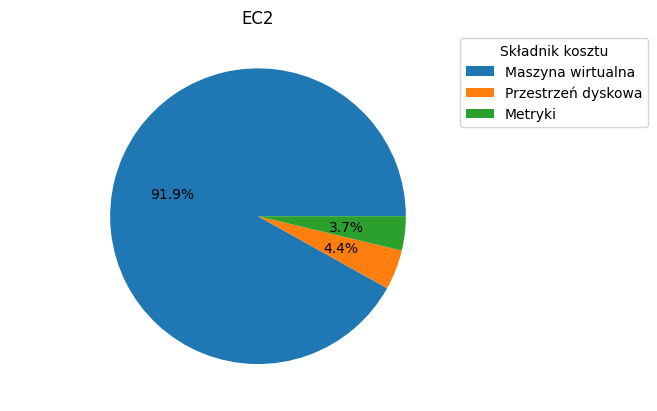

In [66]:
ec2_steady_pricing = [28.03, 1.33, 0.30]
ec2_labels = ['Maszyna wirtualna', 'Przestrzeń dyskowa', 'Metryki']

def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''

fig, ax = plt.subplots()
ax.axis("equal")
ax.set_title('EC2')
wedges, texts, autotexts = ax.pie(ec2_steady_pricing, autopct=my_autopct)
ax.legend(wedges, ec2_labels, title="Składnik kosztu", bbox_to_anchor=(0.8, 0, 0.5, 1))

autotexts

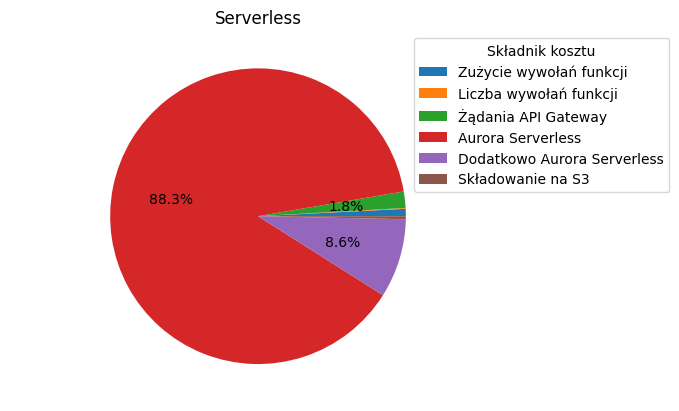

In [65]:
serverless_steady_pricing = [0.4619, 0.0558, 1.0316, 51.1, 5, 0.19]
serverless_labels = ['Zużycie wywołań funkcji', 'Liczba wywołań funkcji', 'Żądania API Gateway', 'Aurora Serverless', 'Dodatkowo Aurora Serverless', 'Składowanie na S3']

def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''

fig, ax = plt.subplots()
ax.axis("equal")
ax.set_title('Serverless')
wedges, texts, autotexts = ax.pie(serverless_steady_pricing, autopct=my_autopct)
ax.legend(wedges, serverless_labels, title="Składnik kosztu", bbox_to_anchor=(0.8, 0, 0.5, 1))